In [1]:
import numpy as np
import pandas as pd
import heapq
import matplotlib.pyplot as plt
import time
import contextily as ctx
import geopandas


## 2.3.1

In [2]:
df_edges = pd.read_csv("edges.tsv", sep="\t")
df_nodes = pd.read_csv("nodes.tsv", sep="\t")
print(df_edges.head())
print(df_nodes.head())

          u           v       length            name
0  12885866    12885923    18.992015      Hlíðartorg
1  12885866  1573411414   653.666145  Reykjanesbraut
2  12885876  1660480490    35.437064      Flatahraun
3  12885876    12885952    16.131272         FH-Torg
4  12885922  2978379988  2587.067864  Reykjanesbraut
      osmid          x          y  primary
0  12885866 -21.937473  64.067271    False
1  12885876 -21.939951  64.076157     True
2  12885922 -22.087890  64.031977    False
3  12885923 -21.937852  64.067260    False
4  12885924 -21.938078  64.067047     True


## 2.3.2

In [3]:
# Input: 
#   -node: 
#   -edges: pandas dataframe of edges
#
# Returns: numpy array of the neighbors of node and distance
def get_neighbors(node_id, edges):
    neighbors = edges.query("u == {0}".format(node_id))
    return neighbors.to_numpy()


In [4]:
# Input: 
#   -start: id of starting node
#   -stations: optional list of osmid of charging stations
#   -nodes: 
#   -edges: 
#
# Returns: 
#   -dist: List of distances where dist[i] is the distance from starting node to node[i]
#   -prev_edge: List of edges where prev_edge[i] is the edge that goes to node [i].
def dijkstra(start, stations=[], nodes=df_nodes, edges=df_edges):
    dist = dict.fromkeys(nodes['osmid'], float("infinity"))
    prev_edge = dict.fromkeys(nodes['osmid'], None)
    dist[start] = 0

    heap = [(0, start)]

    closest_station_distance = float("infinity")

    while heap:
        current_dist, u = heapq.heappop(heap)
        if current_dist > dist[u] or current_dist > closest_station_distance:
            continue  

        if stations and u in stations and current_dist < closest_station_distance:
            closest_station_distance = current_dist

        neighbors = get_neighbors(u, edges)

        for neighbor in neighbors:
            edge_id, neighbor_id, edge_dist, name = neighbor
            new_dist = current_dist + edge_dist

            if new_dist >= dist[neighbor_id] or new_dist >= closest_station_distance:
                continue

            if neighbor_id in (stations or []):
                closest_station_distance = new_dist

            dist[neighbor_id] = new_dist
            prev_edge[neighbor_id] = {
                "u": edge_id,
                "v": neighbor_id,
                "dist": edge_dist,
                "name": name
            }
            heapq.heappush(heap, (new_dist, neighbor_id))

    return  dist, prev_edge

In [5]:
# Leitar að stystu leið frá upphafs staðsetningum í loka staðsetningarnar. Ef lokastaðsetningar eru ekki skilgreindar
# þá leitar það stystu leið í alla punkta. 
#
# Input:
#   -starting_points: pandas dataframe af nodes
#   -end_points: optional pandas dataframe af nodes
#
# Returns: numpy array af dictionaries {station, distances, edges} stundum kallað paths af mér
def leit(starting_points, end_points=None):

    starting_points = starting_points['osmid'].tolist()
    end_points = [] if end_points is None else end_points['osmid'].tolist()

    results = []
    for node in starting_points:
        dist, prev_edge = dijkstra(node, end_points)
        results.append( { "start_position": node, "distances": dist, "edges": prev_edge })

    return np.array(results)

## 2.3.3

In [6]:
# Input: 
#   -paths: Dictinoary {distances, edges} 
#   -stations: List of stations.
# 
# Returns: 
#   -nearest_station_id: int 
#   -shortest_distance: float,
#   -shortest_path: List[edges]
def find_closest_station(paths, stations):
    distances = paths["distances"]
    backtracking_paths = paths["edges"]

    nearest_station_id = min(stations["osmid"].tolist(), key=lambda k: distances[k])

    shortest_distance = distances[nearest_station_id]

    shortest_path = []
    current_position = nearest_station_id
    while distances[current_position] > 0:
        road = backtracking_paths[current_position]
        shortest_path.append(road)
        current_position = road["u"]

    return nearest_station_id, shortest_distance, shortest_path

In [7]:
stations = df_nodes.sample(n=5) # Charging stations
starting_positions = df_nodes.sample(n=5) # Starting positions

starting_position_paths = leit(starting_positions, stations)

In [8]:
# Input: 
#   -node: Upphafsstaðsetning.
# 
# Returns: Listi af punktum
def find_route(path, edges=df_edges, nodes=df_nodes):
    osmid_of_path = list(dict.fromkeys( node for edge in path for node in (edge['u'], edge['v']))) #fjarlægir duplicate nodes og býr til lista af node-id sem eru í leiðinni

    coordinates = [
        [nodes.loc[nodes['osmid'] == osmid, 'x'].values[0],
         nodes.loc[nodes['osmid'] == osmid, 'y'].values[0]]
        for osmid in osmid_of_path
    ]

    return np.array(coordinates)

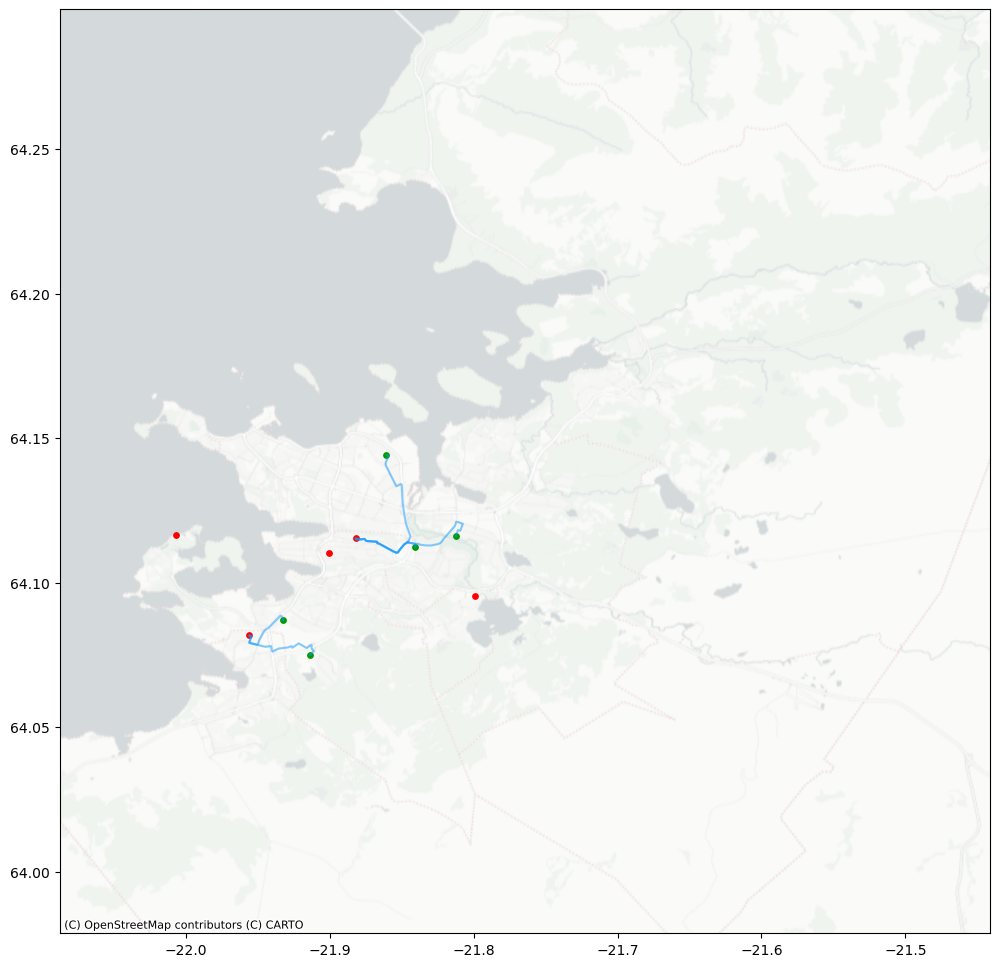

In [11]:
def draw_shortest_paths(starting_positions, stations, starting_position_paths=None):
    if starting_position_paths is None:
        starting_position_paths = leit(starting_positions, stations)

    navigations = []
    for paths in starting_position_paths:
        navigations.append((find_closest_station(paths, stations)))

    #plt.figure(figsize=(15, 12))
    fig, ax = plt.subplots(figsize=(12, 12))


    all_x, all_y = [], []
    for _,_,path in navigations: 
        route = find_route(path)
        ax.plot(route[:, 0],route[:, 1], c='#1099ff', alpha=0.5)
        all_x.extend(route[:, 0])
        all_y.extend(route[:, 1])



    #ax.scatter(df_nodes['x'], df_nodes['y'], c='#dddddd', s=1, alpha=0.5)
    ax.scatter(starting_positions['x'], starting_positions['y'], c='#009900', s=15, alpha=1)
    ax.scatter(stations['x'], stations['y'], c='#ff0000', s=15, alpha=1)

    all_x += df_nodes['x'].tolist() + starting_positions['x'].tolist() + stations['x'].tolist()
    all_y += df_nodes['y'].tolist() + starting_positions['y'].tolist() + stations['y'].tolist()

    # Calculate data bounds with a 10% buffer
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    buffer_x = (max_x - min_x) * 0.0  # 10% buffer
    buffer_y = (max_y - min_y) * 0.0

    # Set axis limits to zoom out
    ax.set_xlim(min_x - buffer_x, max_x + buffer_x)
    ax.set_ylim(min_y - buffer_y, max_y + buffer_y)

    # Add basemap with a lower zoom level (e.g., zoom=10)
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.PositronNoLabels, zoom="auto")

    plt.show()

draw_shortest_paths(starting_positions, stations, starting_position_paths=starting_position_paths)